In [60]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [61]:

# {Legend}, {log}, {Graph Title}
FNAME="../jobs/re2_learning_curves"
curves = defaultdict(list)
with open(FNAME) as f:
    lines = [line.strip()for line in f.readlines() if (not line.startswith("#") and len(line.strip()) > 0)]
    for line in lines:
        legend, log, title = line.split(",")
        curves[title.strip()].append((legend.strip(), log.strip()))

In [62]:
PREFIX = '~/Desktop/zyzzyva/code/ec/'
def extract_curves(log_output, max_iter=33, n_tasks = 500):
    log_output = log_output.split("\\n")
    iters = int(len(log_output) / 2)*2
    # First remove any doubled lines
    cleaned = []
    for i in range(len(log_output) - 1):
        if "Evaluating on" in log_output[i] and not "Hits" in log_output[i+1]:
            continue
        cleaned.append(log_output[i])
    log_ouput = cleaned
    
    x_y = defaultdict(float)
    for i in range(0,iters ,2):
        try:
            iter_line, hits_line = log_output[i], log_output[i+1]
            iter = int(iter_line.split(": ")[-1])
            hits = int(hits_line.split()[1].split("/")[0])
            if iter < max_iter:
                percent = float(hits / n_tasks) * 100
                if percent >= x_y[iter]:
                    x_y[iter] = percent     
        except:
            pass
    if len(x_y) > 0:
        if x_y[0] != 0:
            x_y[0] = 0
    xs, ys = [], []
    for k in sorted(x_y.keys()):
        xs.append(k)
        ys.append(x_y[k])
    
    return xs, ys
        
import subprocess
curve_vals = defaultdict(lambda: defaultdict(list))
for curve in curves:
    print(f"Graph: {curve} with n={len(curves[curve])}")
    for legend, log in curves[curve]:
        p = subprocess.Popen(f"grep -a 'testing tasks' {PREFIX}{log}", stdout=subprocess.PIPE, shell=True)
        output,_ = p.communicate() 
        output = str(output)
        if len(output.strip()) < 2:
            print(f"No output for: {log}")
        else:
            xs, ys = extract_curves(output)
            if len(xs) == 0: print(f"No output for: {log}")
            curve_vals[curve][legend].append((xs, ys))

Graph: "Random Curriculum" with n=16


In [63]:
# Print a table of the best model and the average values for each run
for curve in curve_vals:
    for legend in curve_vals[curve]:
        max_vals = [max(ys) for (xs, ys) in curve_vals[curve][legend] if len(ys) > 0]
        if len(max_vals) > 0:
            print(f"{legend} | Best : {round(np.max(max_vals), 2)} | Average: {round(np.mean(max_vals), 2)} | ")
    print("\n")

Dreamcoder CNN Baseline | Best : 33.8 | Average: 28.3 | 
Language (no generative) | Best : 48.2 | Average: 40.05 | 
Generative Language | Best : 57.0 | Average: 54.1 | 
Generative with Injectivity | Best : 57.0 | Average: 51.3 | 




In [64]:
def build_dataframe(curve_vals, curve):
    # For a given plot, extract all of the 
    iterations = []
    solved_tasks = []
    model = []
    for pal_idx, legend in enumerate(curve_vals[curve]):
        for xs, ys in curve_vals[curve][legend]:
            iterations += xs
            solved_tasks += ys
            model += [legend] * len(xs)
    d = {
            "Iterations" : iterations,
            "% Solved tasks" : solved_tasks,
            "Model" : model
    }
    return pd.DataFrame(data=d)

<Figure size 432x216 with 0 Axes>

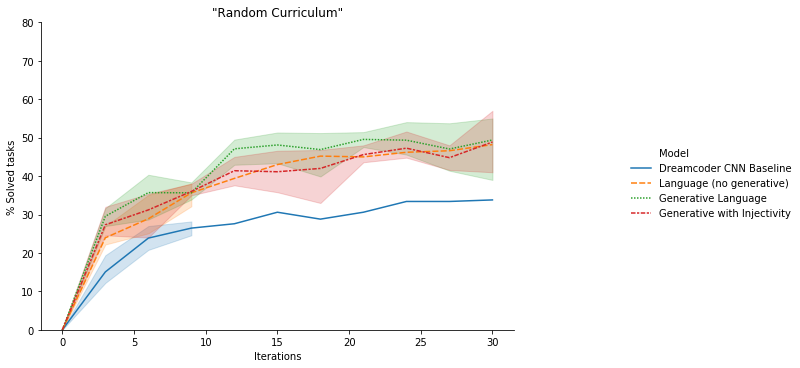

In [65]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
for curve in curve_vals:
    f = plt.figure(figsize=(6,3))
    df = build_dataframe(curve_vals, curve)
    ax = sns.relplot(x="Iterations", y="% Solved tasks",
                hue="Model", style="Model",
                kind="line", data=df)
    ax.fig.set_size_inches(12,5)
    ax.axes[0,0].set_ylim(0, 80)
    plt.title(f"{curve}")